# Demo SingleRun
This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

## Definition of Site

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID="6dbbbdf4-4589-11e9-a501-b469212bff5d",
    geometry=location_from_site,
    capacity=100,
    level=50,
)

to_site = Site(
    env=my_env,
    name="Dumplocatie",
    ID="6dbbbdf5-4589-11e9-82b2-b469212bff5c",
    geometry=location_to_site,
    capacity=50,
    level=0,
)

## Definition of Vessels

In [3]:
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

hopper = TransportProcessingResource(
    env=my_env,
    name="Hopper 01",
    ID="6dbbbdf6-4589-11e9-95a2-b469212bff5b",
    geometry=location_from_site,
    loading_rate=0.00001,
    unloading_rate=0.00001,
    capacity=4,
    compute_v=lambda x: 10,
)

## Definition of process

In [4]:
main_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=hopper,
        destination=from_site,
        postpone_start=True,
        duration=1000,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Loading",
        registry=registry,
        processor=hopper,
        origin=from_site,
        destination=hopper,
        amount=4,
        duration=1000,
        postpone_start=True,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing filled",
        registry=registry,
        mover=hopper,
        destination=to_site,
        postpone_start=True,
        duration=1000,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=hopper,
        origin=hopper,
        destination=to_site,
        amount=4,
        duration=1000,
        postpone_start=True,
        start_event=[
            {
                "name": "prepair",
                "type": "activity",
                "state": "done"
            }
        ]
    ),
    model.BasicActivity(
        env=my_env,
        name="Basic activity",
        registry=registry,
        duration=1000,
        additional_logs=[hopper],
        postpone_start=True,
    ),
]

main_process = model.SequentialActivity(
    env=my_env,
    name="main_process",
    registry=registry,
    sub_processes=main_processes,
    postpone_start=True,
)


helper_processes = [
    model.BasicActivity(
        env=my_env,
        name="prepair",
        registry=registry,
        duration=10000,
        additional_logs=[hopper],
        postpone_start=True,
    ),
    model.BasicActivity(
        env=my_env,
        name="clean-up",
        registry=registry,
        duration=1000,
        additional_logs=[hopper],
        postpone_start=True,
        start_event=[
            {
                "name": "unloading",
                "type": "activity",
                "state": "done"
            }
        ]
    ),
]
helper_process = model.SequentialActivity(
    env=my_env,
    name="helper_process",
    registry=registry,
    sub_processes=helper_processes,
    postpone_start=True,
)

parallel = model.ParallelActivity(
    env=my_env,
    name="parallel",
    registry=registry,
    sub_processes=[helper_process, main_process],
    postpone_start=True,
)


while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[parallel],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
    postpone_start=False,
)

In [5]:
model.register_processes([while_activity])
my_env.run()

In [6]:
plot.get_log_dataframe(hopper, [while_activity, *main_processes, main_process])

,Activity,Timestamp,ActivityState,geometry,container level
0,0667ea23-1393-4eeb-9fc5-94b96b3aa2d4,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0
1,sailing empty,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0
2,sailing empty,1970-01-01 00:16:40,STOP,POINT (4.18055556 52.18664444),0.0
3,Loading,1970-01-01 00:16:40,START,POINT (4.18055556 52.18664444),0.0
4,Loading,1970-01-01 00:16:40,START,POINT (4.18055556 52.18664444),0.0
...,...,...,...,...,...
229,unloading,1970-01-02 19:03:20,STOP,POINT (4.25222222 52.11428333),0.0
230,8a97bbca-e643-4a06-a267-e45d6dc5d34a,1970-01-02 19:03:20,START,POINT (4.25222222 52.11428333),0.0
231,Basic activity,1970-01-02 19:03:20,START,POINT (4.25222222 52.11428333),0.0
232,8a97bbca-e643-4a06-a267-e45d6dc5d34a,1970-01-02 19:20:00,STOP,POINT (4.25222222 52.11428333),0.0


In [7]:
 plot.vessel_planning([*main_processes, *helper_processes])

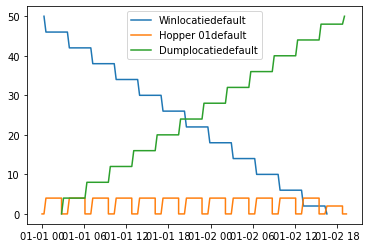

In [8]:
fig = plot.get_step_chart([from_site, hopper, to_site])